# Desafío de data science Itti
![title](../img/itti.png)

In [ ]:
# Maximiliano Angel Uboldi

## 1 - SQL

Para el siguiente ejercicio se tiene una base de datos que tiene el siguiente DER:

![title](../img/img_der.png)


* Persona (id) puede tener muchas Tarjetas (se relaciona a través de `id_titular`)
* Una Compra siempre es realizada con una única tarjeta
* (EXTRA) La tabla Compra posee un histórico de más de 10 años y varias decenas de millones de registros por lo que las consultas a esta entidad pueden tardar varios minutos si no están correctamente optimizadas.

### sql-1) Query

Obtener los número de tarjeta que no tengan consumos en el último mes pero que pertenecen a personas que hayan comprado al menos un total de $5000 en el último mes en los rubros (FARMACIA y SUPERMERCADOS) en conjunto. (Si es posible, tener en cuenta el punto EXTRA mencionado previamente).

In [ ]:
-- Reducimos el número de compras en una CTE a las realizadas en el último mes para optimizar el rendimiento (dependiendo del motor de base de datos, que no sabemos cuál es).
WITH last_month_purchases AS (
    SELECT *
    FROM Compra
    WHERE fecha_compra >= DATEADD(MONTH, -1, CURRENT_DATE)
)
-- Seleccionamos las personas que cumplan con los criterios de compra en farmacia y supermercados (ambos rubros), y al menos 5000 en total.
,qualified_persons AS (
    SELECT
        p.id
    FROM Persona p
    JOIN Tarjeta t
        ON p.id = t.id_titular
    JOIN last_month_purchases c
        ON t.nro_tarjeta = c.nro_tarjeta
    WHERE
        c.rubro IN ('FARMACIA', 'SUPERMERCADOS')
    GROUP BY
        p.id
    HAVING
        SUM(c.monto) >= 5000
        AND COUNT(DISTINCT c.rubro) = 2
)
-- Seleccionamos las tarjetas con las que las personas que cumplieron los criterios anteriores no realizaron compras en el último mes.
SELECT
    t.nro_tarjeta
FROM Tarjeta t
JOIN qualified_persons p
    ON t.id_titular = p.id
WHERE
    NOT EXISTS (
    SELECT 1
    FROM last_month_purchases c
    WHERE c.nro_tarjeta = t.nro_tarjeta
)
;

## 2- Analysis geoespacial 

Se cuenta con el dataset ubicaciones.csv, dicho dataset posee coordenadas de diferentes lugares de interes.
<br>Se sabe que cuando se agrupan 8 lugares o mas esa zona se la considera zona comercial.
<br>Para decir que un local pertenece a la misma zona que otro, deben estar a una distancia menor a 1.2 km
- Crear poligonos con todas las zonas comerciales que se encuentren en el dataset.
- Una vez encontradas marcar su zona de influencia que es dentro del poligono pero tambien hasta 400m de los limites del mismo
- Graficar en un mapa todos los comercios y las zonas de influencia comercial

In [1]:
import folium
import geopandas as gpd
import pandas as pd
from shapely.geometry import mapping
from sklearn.cluster import DBSCAN

In [2]:
df = pd.read_csv("../data/ubicaciones.csv")

In [3]:
df

,latitud,longitud
0,-25.34902,-57.51243
1,-25.26441,-57.45388
2,-25.40697,-54.64246
3,-25.53520,-54.66170
4,-25.30231,-57.49107
...,...,...
995,-25.28084,-57.59942
996,-25.30281,-57.58275
997,-25.26343,-57.57374
998,-26.45446,-55.37798


In [4]:
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["longitud"], df["latitud"]),
    crs="EPSG:4326" # Longitude/Latitude
)

In [ ]:
gdf = gdf.to_crs(epsg=3857) # Web Mercator, metros

In [6]:
coords = list(zip(gdf.geometry.x, gdf.geometry.y))
db = DBSCAN(eps=1200, min_samples=8, metric="euclidean").fit(coords)
gdf["cluster"] = db.labels_

In [7]:
gdf

,latitud,longitud,geometry,cluster
0,-25.34902,-57.51243,POINT (-6402254.422 -2918675.135),0
1,-25.26441,-57.45388,POINT (-6395736.666 -2908256.545),-1
2,-25.40697,-54.64246,POINT (-6082770.823 -2925815.107),-1
3,-25.53520,-54.66170,POINT (-6084912.61 -2941626.432),-1
4,-25.30231,-57.49107,POINT (-6399876.638 -2912922.524),-1
...,...,...,...,...
995,-25.28084,-57.59942,POINT (-6411938.104 -2910279.111),-1
996,-25.30281,-57.58275,POINT (-6410082.408 -2912984.09),1
997,-25.26343,-57.57374,POINT (-6409079.42 -2908135.914),1
998,-26.45446,-55.37798,POINT (-6164648.535 -3055477.511),-1


In [8]:
commercial = gdf[gdf['cluster'] != -1].copy()
clusters = commercial['cluster'].unique()

In [9]:
polygons = []
areas_influence = []
for cl in clusters:
    puntos = commercial[commercial['cluster'] == cl].geometry
    polygon = puntos.union_all().convex_hull
    polygons.append(polygon)
    area_inf = polygon.buffer(400)
    areas_influence.append(area_inf)

In [10]:
gdf_polygons = gpd.GeoDataFrame(
    {'geometry': polygons}, crs='EPSG:3857').to_crs(epsg=4326)
gdf_influence = gpd.GeoDataFrame(
    {'geometry': areas_influence}, crs='EPSG:3857').to_crs(epsg=4326)
gdf = gdf.to_crs(epsg=4326)

In [11]:
center = [gdf.geometry.y.mean(), gdf.geometry.x.mean()]
map_var = folium.Map(location=center, zoom_start=10)

In [12]:
for _, row in gdf.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,
        color='grey',
        fill=True,
        fill_opacity=0.7
    ).add_to(map_var)

In [13]:
for _, row in gdf_influence.iterrows():
    folium.GeoJson(
        mapping(row.geometry),
        style_function=lambda x: {
            'color': 'red', 'weight': 2, 'fill': False, 'dashArray': '5, 5'},
        name='Zona de Influencia'
    ).add_to(map_var)

In [14]:
for _, row in gdf_polygons.iterrows():
    folium.GeoJson(
        mapping(row.geometry),
        style_function=lambda x: {'color': 'blue', 'weight': 2, 'fill': False},
        name='Zona Comercial'
    ).add_to(map_var)

In [15]:
folium.LayerControl().add_to(map_var)

In [16]:
map_var

## 3- Machine Learning

# Problema de Retención de Clientes en el Banco PY

Se desea resolver el siguiente problema: 

El banco PY está notando que muchos clientes se están acercando a cerrar su cuenta, lo cual les preocupa. Decidieron implementar una estrategia de retención muy agresiva que, a su vez, es costosa ya que bonifica productos y otorga descuentos que no se ven normalmente en el mercado. 

Se ha observado en un pequeño experimento que, a pesar de ser una oferta irresistible, cuando un cliente le indica al banco que se quiere dar de baja, ya no hay vuelta atrás. Por esta razón, se desea que los ejecutivos sepan con anticipación cuándo un cliente tiene altas probabilidades de pedir la baja, a pesar de que el motivo de acercarse al banco sea otro. De esta manera, al recibir al cliente, ya se pueden preparar para retenerlos.

## Descripción Operativa

Cuando un cliente entra en una sucursal, tiene un tótem en donde se registra e indica el motivo de su visita. Esto le genera el turno y, con él, espera a ser atendido por un ejecutivo. 

El banco posee varias sucursales en Asunción que se gestionan en dos zonas: una céntrica y otra en las afueras. Esta definición no solo tiene que ver con la locación, sino también con el comportamiento y la tolerancia de los clientes.

Hoy en día, el equipo de Data Science tiene funcionando un modelo, pero no es suficientemente bueno para la nueva estrategia que propone el equipo comercial, por lo que desean reemplazarlo por uno nuevo.

## Objetivos

* Desarrollar un modelo de Machine Learning que prediga churn.
* Definir cómo sería la implementación y cuándo se usaría.
* Explicar la elección del algoritmo utilizado
* Explicar los resultados obtenidos (Métricas) y si tiene el rendimiento necesario para salir a producción.
* Explicar cuales son las variables que más afectan a la predicción.
* Contestar las siguientes preguntas:
  * *¿El modelo final elegido es bueno? Justificar*
  * *¿Existe overfitting o underfitting?* 

⚠️**ACLARACIONES:**⚠️

- Se tendrá en cuenta la prolijidad del informe. 
- Se tendrá en cuenta la legibilidad del código.
- De ser necesario, dejar asentado los supuestos utilizados por escrito.

## Recursos Disponibles

Para resolver el desafío, se cuenta con:

- Un dataset que contiene las visitas de nuestros clientes a las sucursales y otro de zonas. Esta información consta de datos obtenidos del tótem y del CRM del ejecutivo.
- Un modelo actual (función de Python para hacer predicciones).
- Datos de costo promedio de la estrategia de retención y rentabilidad esperada del cliente en los 3 primeros meses luego de retenerlo, rentabilidad esperada del cliente en el primer año luego de retenerlo, y rentabilidad del cliente en la última acción de darse de baja.

## Descripción del dataset
- cliente_id: id del cliente que se registra en el totem de la sucursal
- segmento_cliente: segmento del cliente, se obtiene con un modelo de ML que segmenta a los clientes según su comportamiento
- tipo_asistencia: la accion que declara el cliente que viene a hacer al banco cuando se registra en el totem. En los últimos meses de volvió opcional
- descripcion_atencion: cuando el cliente se registra le dice al totem con su voz qué es lo que viene a hacer al banco, un modelo de IA lo traduce en tiempo real. El cliente también tiene la opción de hacerlo escribiendo en un teclado.
- coordenadas_sucursal: coordenadas geográficas en donde se encuentra la sucursal de la atención
- inicio_atencion_utc: fecha y hora de inicio de llegada a la sucursa (registro en totem). El huso horario es UTC+0
- fin_atencion: fecha y hora de fin de atención marcada desde el CRM del ejecutivo cuando cierra la atención. El huso horario es UTC-3 hora de Paraguay
- puntos_de_loyalty: puntos acumulados en el sistema de loyalty
- edad: edad del cliente
- churn: indica si luego de la atención el cliente se dio de baja del banco o no. Se completa automáticamente desde el CRM por el ejecutivo.

- zona: nombre de la zona de atención
- poligono: coordenadas del contorno del polígono correspondiente a cada zona

In [17]:
import ast
import gc
import json
import os
import random
import time
import warnings

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import CatBoostEncoder
from feature_engine.encoding import OneHotEncoder
from feature_engine.imputation import EndTailImputer
from feature_engine.selection import DropConstantFeatures
from feature_engine.wrappers import SklearnTransformerWrapper
from imblearn.ensemble import (BalancedBaggingClassifier,
                               BalancedRandomForestClassifier,
                               EasyEnsembleClassifier, RUSBoostClassifier)
from lightgbm import LGBMClassifier
from matplotlib.ticker import StrMethodFormatter
from mlxtend.evaluate.time_series import GroupTimeSeriesSplit
from shapely.geometry import Point, Polygon
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from utils import (compute_metrics, plot_feature_importance,
                   plot_shap_importance)
from xgboost import XGBClassifier

In [18]:
df = pd.read_csv(
    "../data/dataset_churn_challenge.csv",
    dtype={
        "cliente_id": "object",
        "segmento_cliente": "object",
        "tipo_asistencia": "object",
        "descripcion_atencion": "object",
        "coordenadas_sucursal": "object",
        "inicio_atencion_utc": "object",
        "fin_atencion": "object",
        "puntos_de_loyalty": "float64",
        "edad": "int64",
        "churn": "int8"
    },
    parse_dates=["inicio_atencion_utc", "fin_atencion"],
)
# Adecuamos la zona horaria
df["inicio_atencion"] = df["inicio_atencion_utc"].dt.tz_convert(
    "America/Asuncion")
df = df.drop(columns=["inicio_atencion_utc"])
df["fin_atencion"] = df["fin_atencion"].dt.tz_localize("America/Asuncion")

In [19]:
df_zonas = pd.read_csv("../data/dataset_churn_zona_challenge.csv")

In [20]:
# Procesamos las coordenadas
df["geometry"] = df["coordenadas_sucursal"].apply(
    lambda x: Point(json.loads(x)["longitud"], json.loads(x)["latitud"])
)
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

In [21]:
gdf_zonas = gpd.GeoDataFrame(
    df_zonas,
    geometry=df_zonas["poligono"].apply(
        lambda x: Polygon(ast.literal_eval(x))),
    crs="EPSG:4326"
)

In [22]:
# Traemos las zonas
gdf_final = gpd.sjoin(
    gdf,
    gdf_zonas[["zona", "geometry"]],
    how="left",
    predicate="within"
)

In [23]:
# Hacemos limpieza
dataset = pd.DataFrame(gdf_final.drop(
    columns=["geometry", "index_right", "coordenadas_sucursal"]))

In [24]:
del df, df_zonas, gdf, gdf_zonas, gdf_final
gc.collect()

22

In [25]:
dataset

,cliente_id,segmento_cliente,tipo_asistencia,descripcion_atencion,fin_atencion,puntos_de_loyalty,edad,churn,inicio_atencion,zona
0,12462,C2,soporte,Estoyaquí Para pedir ayudacon Un Error Tuerca ...,2024-01-01 15:08:39.861786534-03:00,3149.471104,40,1,2024-01-01 14:52:00-03:00,zona_1
1,7471,B1,soporte,vengo Porqu Necesito Asistencia Con Mi Tarjeta...,2024-01-01 10:31:01.452232488-03:00,5327.590530,51,0,2024-01-01 10:00:00-03:00,zona_1
2,43237,D3,problema,Estoy aquí Porque mi cuenta ha sido Bloqueada,2024-01-01 12:17:10.491604314-03:00,3105.681258,47,0,2024-01-01 11:45:00-03:00,zona_1
3,25235,C7,consulta,Estoy interesado e Saber Másobre losbeneficios...,2024-01-01 16:17:54.884666088-03:00,3063.190862,33,0,2024-01-01 15:58:00-03:00,zona_1
4,68218,B8,consulta,Necesito idea sobre cómo Cambiar Mis datos per...,2024-01-01 15:36:38.272183704-03:00,6113.842796,47,0,2024-01-01 15:20:00-03:00,zona_2
...,...,...,...,...,...,...,...,...,...,...
765726,246142,A7,reclamo,tengo una queja porqu no Estoy satisfech con l...,2025-03-31 11:48:24.181631238-03:00,6309.309985,44,0,2025-03-31 12:33:00-03:00,zona_2
765727,268173,C5,consulta,Quiero Hacer preguntas sobr Los Préstamos pers...,2025-03-31 11:38:36.637487556-03:00,5872.939135,49,0,2025-03-31 12:29:00-03:00,zona_2
765728,301366,C2,reclamo,Tengo Una Queja Sobre la Demora En el Servicio.,2025-03-31 11:15:19.875735450-03:00,4823.284518,42,1,2025-03-31 11:55:00-03:00,zona_1
765729,193475,A2,soporte,Quiero que me expliquen Cómo hacetransferencia...,2025-03-31 14:42:15.573126456-03:00,5178.080873,36,1,2025-03-31 15:15:00-03:00,zona_2


In [26]:
def predecir_churn(tipo_asistencia):
    tipo_asistencia = str(tipo_asistencia)
    if tipo_asistencia.lower() == "problema":
        return 1.0  # Siempre devuelve 1 si es un problema
    elif tipo_asistencia.lower() == "reclamo":
        return 0.8 if random.random() < 0.5 else 0  # 50% de probabilidad para reclamos
    else:
        return 0

### Costos y rentabilidad
- Costo de estrategia de retención 20
- Rentabilidad del cliente en corto plazo 8
- Rentabilidad del cliente en largo plazo 50
- Rentabilidad del cliente que se da de baja -2

## EDA

In [27]:
dataset.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
cliente_id,765731,297885,15060,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
segmento_cliente,765731,31,C4,38142,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tipo_asistencia,619179,4,consulta,247318,NaN,NaN,NaN,NaN,NaN,NaN,NaN
descripcion_atencion,765731,732022,Necesito Asesoramiento Sobre Ahorro para Mi ju...,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fin_atencion,765731,NaN,NaN,NaN,2024-08-15 08:08:02.075785216-04:00,2024-01-01 10:08:44.754428730-03:00,2024-04-24 14:59:35.267814912-04:00,2024-08-14 12:32:47.661227776-04:00,2024-12-06 11:38:47.825336064-03:00,2025-03-31 16:45:04.619943126-03:00,NaN
puntos_de_loyalty,765731.0,NaN,NaN,NaN,4851.133035,123.47367,4159.488868,4853.554087,5544.878457,9464.957703,1025.265643
edad,765731.0,NaN,NaN,NaN,42.553482,18.0,36.0,43.0,49.0,93.0,9.957738
churn,765731.0,NaN,NaN,NaN,0.297778,0.0,0.0,0.0,1.0,1.0,0.457282
inicio_atencion,765731,NaN,NaN,NaN,2024-08-15 07:48:00.797121024-04:00,2024-01-01 10:00:00-03:00,2024-04-24 14:38:30-04:00,2024-08-14 12:13:00-04:00,2024-12-06 11:18:30-03:00,2025-03-31 16:59:00-03:00,NaN
zona,765731,2,zona_2,494293,NaN,NaN,NaN,NaN,NaN,NaN,NaN


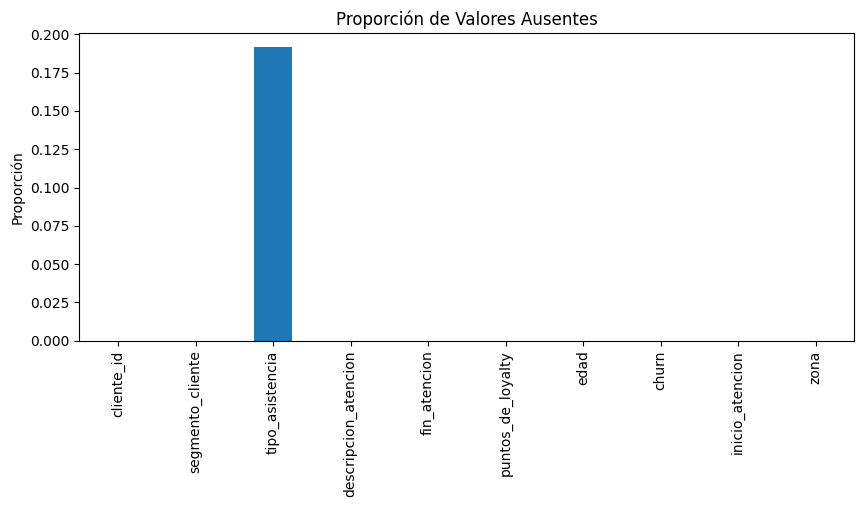

In [28]:
(dataset.isnull().sum() / len(dataset)).plot(
    kind='bar',
    figsize=(10,4),
    title='Proporción de Valores Ausentes',
    ylabel='Proporción'
)
plt.show()

In [29]:
# Parece que el 01/01/25 se volvió opcional
optional = dataset[dataset["tipo_asistencia"].isnull()]["inicio_atencion"].min()
optional

Timestamp('2025-01-01 10:00:00-0300', tz='America/Asuncion')

In [30]:
# Hay demasiado nulo luego de que se volvió opcional, sería arriesgado usarlo como feature
dataset.query("inicio_atencion >= @optional")[
    "tipo_asistencia"].value_counts(dropna=False, normalize=True)

tipo_asistencia
NaN         0.983201
consulta    0.006910
reclamo     0.005085
soporte     0.003160
problema    0.001644
Name: proportion, dtype: float64

In [31]:
dataset["time_diff_min"] = (
    dataset["fin_atencion"] - dataset["inicio_atencion"]
).dt.total_seconds() / 60

In [32]:
dataset["time_diff_min"].describe()

count    765731.000000
mean         20.021311
std          13.619091
min         -60.000000
25%          13.356522
50%          18.806137
75%          26.195057
max         114.151708
Name: time_diff_min, dtype: float64

In [33]:
# Parece que hay tiempos negativos, esto podría indicar problemas de calidad que habría que revisar...
dataset.query("time_diff_min < 0")

,cliente_id,segmento_cliente,tipo_asistencia,descripcion_atencion,fin_atencion,puntos_de_loyalty,edad,churn,inicio_atencion,zona,time_diff_min
752608,188834,B10,NaN,Estoy Aqupara Aclarar Dudas sobre locargos En ...,2025-03-24 11:58:51.208456626-03:00,4338.585733,32,0,2025-03-24 12:34:00-03:00,zona_2,-35.146526
752609,101674,B7,NaN,Vine Porque mi saldo No Coincide Co Lo Que apa...,2025-03-24 13:05:24.569694318-03:00,4796.180974,39,0,2025-03-24 13:45:00-03:00,zona_2,-39.590505
752610,276404,B7,NaN,estoy Buscando Ayuda Para Resolver U problema ...,2025-03-24 14:57:50.788653408-03:00,3147.977425,43,0,2025-03-24 15:38:00-03:00,zona_2,-40.153522
752611,294214,C1,NaN,quiero saber cómo Proteger mejomi cuentcontra ...,2025-03-24 15:35:15.217395167-03:00,3697.596238,38,0,2025-03-24 16:16:00-03:00,zona_2,-40.746377
752612,107735,B6,NaN,quier queme Expliquen cómhacer transferencias ...,2025-03-24 14:18:35.491244982-03:00,5324.849821,43,0,2025-03-24 14:47:00-03:00,zona_2,-28.408479
...,...,...,...,...,...,...,...,...,...,...,...
765726,246142,A7,reclamo,tengo una queja porqu no Estoy satisfech con l...,2025-03-31 11:48:24.181631238-03:00,6309.309985,44,0,2025-03-31 12:33:00-03:00,zona_2,-44.596973
765727,268173,C5,consulta,Quiero Hacer preguntas sobr Los Préstamos pers...,2025-03-31 11:38:36.637487556-03:00,5872.939135,49,0,2025-03-31 12:29:00-03:00,zona_2,-50.389375
765728,301366,C2,reclamo,Tengo Una Queja Sobre la Demora En el Servicio.,2025-03-31 11:15:19.875735450-03:00,4823.284518,42,1,2025-03-31 11:55:00-03:00,zona_1,-39.668738
765729,193475,A2,soporte,Quiero que me expliquen Cómo hacetransferencia...,2025-03-31 14:42:15.573126456-03:00,5178.080873,36,1,2025-03-31 15:15:00-03:00,zona_2,-32.740448


In [34]:
# Dropeamos el fin de atención, nos vamos a enforcar en el inicio de la atención para la evaluación temporal
dataset = dataset.drop(
    columns=["time_diff_min", "fin_atencion"], errors='ignore')

In [35]:
# Mi costumbre, para estandarizar el nombre
dataset = dataset.rename(columns={"churn": "target"})

In [36]:
dataset

,cliente_id,segmento_cliente,tipo_asistencia,descripcion_atencion,puntos_de_loyalty,edad,target,inicio_atencion,zona
0,12462,C2,soporte,Estoyaquí Para pedir ayudacon Un Error Tuerca ...,3149.471104,40,1,2024-01-01 14:52:00-03:00,zona_1
1,7471,B1,soporte,vengo Porqu Necesito Asistencia Con Mi Tarjeta...,5327.590530,51,0,2024-01-01 10:00:00-03:00,zona_1
2,43237,D3,problema,Estoy aquí Porque mi cuenta ha sido Bloqueada,3105.681258,47,0,2024-01-01 11:45:00-03:00,zona_1
3,25235,C7,consulta,Estoy interesado e Saber Másobre losbeneficios...,3063.190862,33,0,2024-01-01 15:58:00-03:00,zona_1
4,68218,B8,consulta,Necesito idea sobre cómo Cambiar Mis datos per...,6113.842796,47,0,2024-01-01 15:20:00-03:00,zona_2
...,...,...,...,...,...,...,...,...,...
765726,246142,A7,reclamo,tengo una queja porqu no Estoy satisfech con l...,6309.309985,44,0,2025-03-31 12:33:00-03:00,zona_2
765727,268173,C5,consulta,Quiero Hacer preguntas sobr Los Préstamos pers...,5872.939135,49,0,2025-03-31 12:29:00-03:00,zona_2
765728,301366,C2,reclamo,Tengo Una Queja Sobre la Demora En el Servicio.,4823.284518,42,1,2025-03-31 11:55:00-03:00,zona_1
765729,193475,A2,soporte,Quiero que me expliquen Cómo hacetransferencia...,5178.080873,36,1,2025-03-31 15:15:00-03:00,zona_2


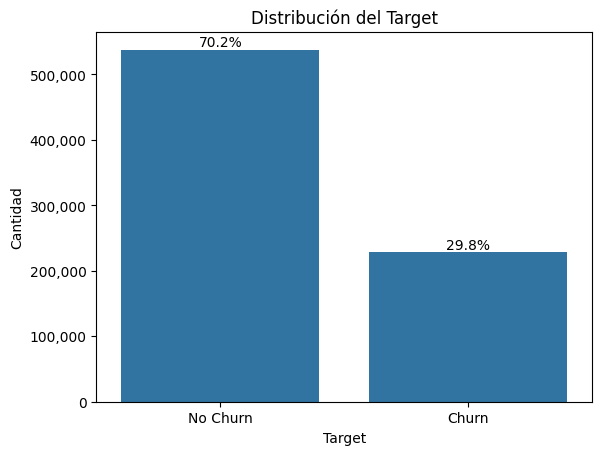

In [37]:
ax = sns.countplot(
    data=dataset,
    x="target"
)
ax.set_xlabel("Target")
ax.set_ylabel("Cantidad")
ax.set_title(
    "Distribución del Target"
)

ax.set_xticks([0, 1])
ax.set_xticklabels(["No Churn", "Churn"])

ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))

for p in ax.patches:
    height = p.get_height()
    percentage = (height / len(dataset)) * 100
    ax.annotate(
        text=f"{percentage:.1f}%",
        xy=(p.get_x() + p.get_width() / 2., height),
        ha="center",
        va="center",
        xytext=(0, 5),
        textcoords="offset points"
    )
plt.show()

In [38]:
# Solo por si acaso, no sea cosa que un mismo cliente tenga múltiples churns...
dataset.groupby("cliente_id")["target"].sum(
).sort_values(ascending=False).head(10)

cliente_id
1         1
276771    1
276704    1
276705    1
276707    1
27671     1
276710    1
276711    1
276712    1
276714    1
Name: target, dtype: int8

In [39]:
dataset = dataset.sort_values("inicio_atencion")

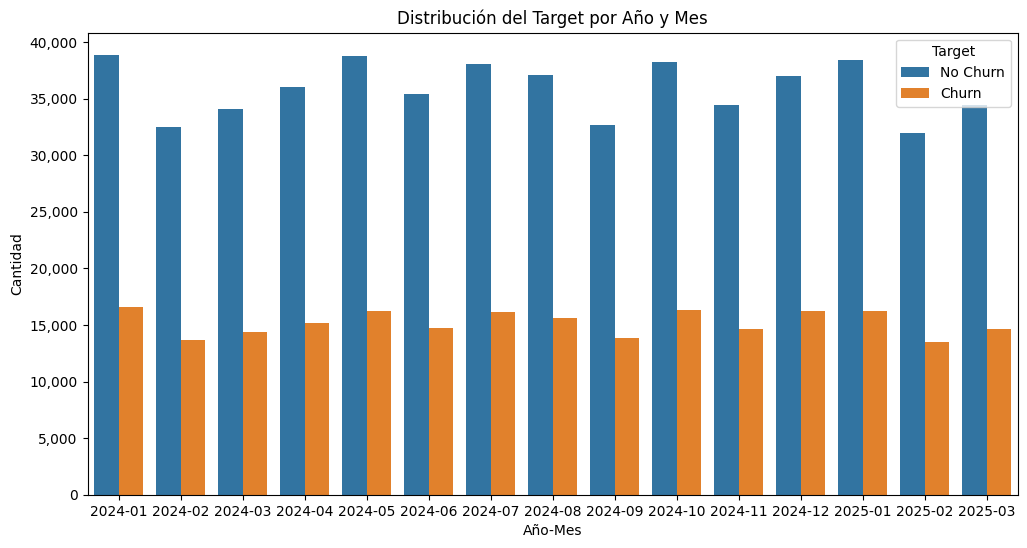

In [40]:
df = dataset[["inicio_atencion", "target"]].copy()
df["Año-Mes"] = df["inicio_atencion"].astype(str).str.slice(0, 7)
df["Target"] = df["target"].map({0: "No Churn", 1: "Churn"})

plt.figure(figsize=(12, 6))
ax = sns.countplot(
    data=df,
    x="Año-Mes",
    hue="Target"
)
ax.set_ylabel("Cantidad")
ax.set_title(
    "Distribución del Target por Año y Mes"
)
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))

plt.show()

## Separación de entrenamiento y prueba

Si bien en la práctica real la correspondencia temporal para la definición de los conjuntos de entrenamiento y test dependen de la experimentación, a los fines de simplificar el ejercicio se define utilizar un esquema mensual, dejando el último mes para la prueba (conjunto de test).

In [41]:
%%capture
dataset["periodo"] = dataset["inicio_atencion"].dt.to_period("M").astype(str)
dataset = dataset.drop(columns=["inicio_atencion"], errors='ignore')

In [42]:
dates = dataset["periodo"].unique()
train_date = list(dates[:-1])
test_date = [dates[-1]]
print(train_date)
print(test_date)

['2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02']
['2025-03']


In [43]:
train_dataset = dataset.query("periodo in @train_date").copy()
test_dataset = dataset.query("periodo in @test_date").copy()
print(train_dataset.shape)
print(test_dataset.shape)

(716681, 9)
(49050, 9)


## Definición de métrica de negocio

Se define la métrica de negocio siguiendo los supuestos detallados a continuación y basados en los parámetros indicados:

- *TP (True Positive)*: el modelo predice que el cliente se dará de baja y acierta. Se aplica la estrategia de retención (costo 20), y si el cliente se queda, se obtiene la rentabilidad de largo plazo (50). El beneficio neto sería 50 - 20 = 30.
- *FP (False Positive)*: el modelo predice la baja pero el cliente no se va. Se aplica la estrategia de retención (costo 20), pero el cliente igual se queda (rentabilidad a corto plazo 8). El beneficio neto es 8 - 20 = -12 (castigamos con la rentabilidad de corto plazo el error).
- *TN (True Negative)*: el modelo predice que el cliente no se da de baja y acierta. Se obtiene la rentabilidad de corto plazo (8).
- *FN (False Negative)*: el modelo no predice la baja pero el cliente se va. No se aplica la estrategia de retención, se pierde al cliente (rentabilidad de baja: -2).

Por lo tanto, los parámetros serían:

amount_tp = 30
amount_tn = 8
amount_fp = -12
amount_fn = -2

## Métrica del modelo actual

In [44]:
train_data = train_dataset.drop(columns=["target"])
test_data = test_dataset.drop(columns=["target"])
train_target = train_dataset["target"]
test_target = test_dataset["target"]

In [45]:
pred_scores = test_data["tipo_asistencia"].apply(predecir_churn)
metrics = compute_metrics(
    y_true=test_target,
    y_score=pred_scores,
    y_pred=np.where(
        pred_scores > 0.5,
        1,
        0
    )
)
print("Metrics")
for m, s in metrics.items():
    print("%s: %.4f" % (m, s))

Metrics
roc_score: 0.5004
ks_statistic: 0.0020
pr_score: 0.2985
accuracy_score: 0.6974
balanced_accuracy_score: 0.5004
precision_score: 0.3110
precision_score_weighted: 0.5857
recall_score: 0.0130
recall_score_weighted: 0.6974
f1_score: 0.0250
f1_score_weighted: 0.5838
business_metric: 243940.0000


## Definición de variables

In [46]:
# Esta variable la descartamos por su nivel de nulos al volverse opcional
train_dataset = train_dataset.drop(
    columns=["tipo_asistencia"], errors='ignore')
test_dataset = test_dataset.drop(columns=["tipo_asistencia"], errors='ignore')

## Selección de algoritmos

Vamos a evaluar una multiplicidad de algoritmos con sus hiperparámetros por defecto para ver el que mejor funciona para el problema. La idea es evaluar por la métrica de negocio el que mejor funciona, para luego concentrarse en ese algoritmo. Lo ideal sería seleccionar el algoritmo y optimizar al mismo tiempo, pero esta forma nos permite enforcar esfuerzos en el que potencialmente es mejor, reduciendo el tiempo de desarrollo posterior. La validación se hace en 5 bloques temporales mensuales. El preprocesamiento de las variables se define por criterio, no está optimizado.

In [47]:
TRAIN_DATES = [
    "2024-09",
    "2024-10",
    "2024-11",
    "2024-12",
    "2025-01",
    "2025-02"
]
N_JOBS = max(os.cpu_count() - 1, 1)
SEED = 8888
categorical_to_encode = [
    "segmento_cliente",
    "zona"
]
numerical_to_encode = [
    "edad",
    "puntos_de_loyalty"
]

In [48]:
train_data = train_dataset.copy()
train_data = train_data[train_data["periodo"].isin(TRAIN_DATES)]

train_data = train_data.drop(columns=["cliente_id"])
train_data = train_data.set_index("periodo")

train_target = train_data["target"].copy()
train_data = train_data.drop(columns=["target"]).copy()

In [49]:
preprocessor = Pipeline(
    steps=[
        ("cat_encoder", CatBoostEncoder(
            random_state=SEED,
            cols=categorical_to_encode,
        ),
        ),
        ("num_encoder", EndTailImputer(
            imputation_method="iqr",
            tail="left",
            fold=5,
            variables=numerical_to_encode,
        ),
        ),
        ("drop_constant", DropConstantFeatures(
            tol=0.95, missing_values="include"
        ),
        ),
    ]
)

column_transformer = ColumnTransformer(
    transformers=[
        ("tfidf", TfidfVectorizer(
            strip_accents="ascii",
            lowercase=True,
            ngram_range=(1, 2),
            max_features=500,
            max_df=0.95,
            min_df=2,
        ), "descripcion_atencion"),
        ("preprocessor", preprocessor, categorical_to_encode
         + numerical_to_encode),
    ],
    remainder="drop",
    sparse_threshold=0
)

models = [
    ("Dummy", Pipeline(
        steps=[
            ("features", column_transformer),
            ("model", DummyClassifier()),
        ]
    ),
    ),
    ("LogisticRegression", Pipeline(
        steps=[
            ("features", column_transformer),
            ("scaler", SklearnTransformerWrapper(StandardScaler())),
            ("model", LogisticRegression(
                penalty=None, solver="lbfgs", random_state=SEED)),
        ]
    ),
    ),
    ("LassoLogisticRegression", Pipeline(
        steps=[
            ("features", column_transformer),
            ("scaler", SklearnTransformerWrapper(StandardScaler())),
            ("model", LogisticRegression(
                penalty="l1", solver="saga", random_state=SEED)),
        ]
    ),
    ),
    ("RidgeLogisticRegression", Pipeline(
        steps=[
            ("features", column_transformer),
            ("scaler", SklearnTransformerWrapper(StandardScaler())),
            ("model", LogisticRegression(
                penalty="l2", solver="lbfgs", random_state=SEED)),
        ]
    ),
    ),
    ("ElasticNetLogisticRegression", Pipeline(
        steps=[
            ("features", column_transformer),
            ("scaler", SklearnTransformerWrapper(StandardScaler())),
            ("model", LogisticRegression(
                penalty="elasticnet",
                solver="saga",
                l1_ratio=0.5,
                random_state=SEED)
             ),
        ]
    ),
    ),
    ("KNeighbors", Pipeline(
        steps=[
            ("features", column_transformer),
            ("scaler", SklearnTransformerWrapper(MinMaxScaler())),
            ("model", KNeighborsClassifier(n_jobs=N_JOBS)),
        ]
    ),
    ),
    ("LightGBM", Pipeline(
        steps=[
            ("features", column_transformer),
            ("model", LGBMClassifier(
                random_state=SEED,
                n_jobs=N_JOBS,
                verbose=-1)
             ),
        ]
    ),
    ),
    ("XGBoost", Pipeline(
        steps=[
            ("features", column_transformer),
            ("model", XGBClassifier(random_state=SEED, n_jobs=N_JOBS)),
        ]
    ),
    ),
    ("ExtraTrees", Pipeline(
        steps=[
            ("features", column_transformer),
            ("model", ExtraTreesClassifier(random_state=SEED, n_jobs=N_JOBS)),
        ]
    ),
    ),
    ("RandomForest", Pipeline(
        steps=[
            ("features", column_transformer),
            ("model", RandomForestClassifier(
                random_state=SEED,
                n_jobs=N_JOBS)
             ),
        ]
    ),
    ),
    ("SGDSVM", Pipeline(
        steps=[
            ("features", column_transformer),
            ("scaler", SklearnTransformerWrapper(StandardScaler())),
            ("model", CalibratedClassifierCV(
                SGDClassifier(
                    loss="hinge",
                    n_jobs=N_JOBS,
                    random_state=SEED,
                ),
                method="sigmoid",
                cv=None,
                n_jobs=N_JOBS,
                ensemble=True,
            )),
        ]
    ),
    ),
    ("EasyEnsemble", Pipeline(
        steps=[
            ("features", column_transformer),
            ("model", EasyEnsembleClassifier(
                random_state=SEED,
                n_jobs=N_JOBS)
             ),
        ]
    ),
    ),
    ("RUSBoost", Pipeline(
        steps=[
            ("features", column_transformer),
            ("model", RUSBoostClassifier(random_state=SEED)),
        ]
    ),
    ),
    ("BalancedBagging", Pipeline(
        steps=[
            ("features", column_transformer),
            ("model", BalancedBaggingClassifier(
                random_state=SEED, n_jobs=N_JOBS)),
        ]
    ),
    ),
    ("BalancedRandomForest", Pipeline(
        steps=[
            ("features", column_transformer),
            ("model", BalancedRandomForestClassifier(
                random_state=SEED,
                n_jobs=N_JOBS,
                sampling_strategy="all",
                replacement=True,
                bootstrap=True
            )),
        ]
    ),
    ),
]

In [50]:
model_metrics_list = []

for model, learner in models:

    print("Running model: %s" % model)
    metrics_list = []
    for train_index, valid_index in GroupTimeSeriesSplit(
        test_size=1, train_size=1).split(
            train_data,
            train_target,
            list(train_data.index)
    ):

        start_time = time.time()

        train_data_fold = train_data.iloc[train_index].copy()
        train_target_fold = train_target.iloc[train_index].copy()

        val_data_fold = train_data.iloc[valid_index].copy()
        val_target_fold = train_target.iloc[valid_index].copy()

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            learner.fit(train_data_fold, train_target_fold)

        pred_score_fold = learner.predict_proba(val_data_fold)[:, -1]
        pred_target_fold = np.where(pred_score_fold > 0.5, 1, 0)

        metrics_fold = compute_metrics(
            y_true=val_target_fold,
            y_score=pred_score_fold,
            y_pred=pred_target_fold,
        )
        metrics_fold.update({"TT_secs": time.time() - start_time})
        metrics_list.append(metrics_fold)

    metrics = pd.DataFrame(metrics_list)
    metrics.columns = metrics.columns.str.upper()
    metrics = metrics.mean().to_frame().T
    metrics.index = [model]

    model_metrics_list.append(metrics)

    # Save metrics at each iteration
    final_metrics = pd.concat(model_metrics_list).round(4)
    final_metrics.index.name = "MODEL"

Running model: Dummy
Running model: LogisticRegression
Running model: LassoLogisticRegression
Running model: RidgeLogisticRegression
Running model: ElasticNetLogisticRegression
Running model: KNeighbors
Running model: LightGBM
Running model: XGBoost
Running model: ExtraTrees
Running model: RandomForest
Running model: SGDSVM
Running model: EasyEnsemble
Running model: RUSBoost
Running model: BalancedBagging
Running model: BalancedRandomForest


In [51]:
final_metrics.sort_values(
    "BUSINESS_METRIC",
    ascending=False
).style.highlight_max(
    subset=[col for col in metrics.columns if col != "TT_SECS"],
    color="green"
).applymap(lambda x: "background-color: gray", subset=["TT_SECS"])

,ROC_SCORE,KS_STATISTIC,PR_SCORE,ACCURACY_SCORE,BALANCED_ACCURACY_SCORE,PRECISION_SCORE,PRECISION_SCORE_WEIGHTED,RECALL_SCORE,RECALL_SCORE_WEIGHTED,F1_SCORE,F1_SCORE_WEIGHTED,BUSINESS_METRIC,TT_SECS
MODEL,,,,,,,,,,,,,
LogisticRegression,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,749669.200000,2.540100
LassoLogisticRegression,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,749669.200000,23.954800
RidgeLogisticRegression,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,749669.200000,2.373500
ElasticNetLogisticRegression,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,749669.200000,24.906300
LightGBM,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,749669.200000,1.658400
XGBoost,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,749669.200000,2.325600
ExtraTrees,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,749669.200000,5.814100
RandomForest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,749669.200000,4.748500
SGDSVM,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,749669.200000,11.297300


## Análisis del modelo

In [52]:
preprocessor = Pipeline(
    steps=[
        ("cat_encoder", CatBoostEncoder(
            random_state=SEED,
            cols=categorical_to_encode,
        ),
        ),
        ("num_encoder", EndTailImputer(
            imputation_method="iqr",
            tail="left",
            fold=5,
            variables=numerical_to_encode,
        ),
        ),
        ("drop_constant", DropConstantFeatures(
            tol=0.95, missing_values="include"
        ),
        ),
    ]
)

column_transformer = ColumnTransformer(
    transformers=[
        ("tfidf", TfidfVectorizer(
            strip_accents="ascii",
            lowercase=True,
            ngram_range=(1, 2),
            max_features=500,
            max_df=0.95,
            min_df=2,
        ), "descripcion_atencion"),
        ("preprocessor", preprocessor, categorical_to_encode
         + numerical_to_encode),
    ],
    remainder="drop",
    sparse_threshold=0
)
pipeline = Pipeline(
    steps=[
        ("features", column_transformer),
        ("model", LGBMClassifier(
            random_state=SEED,
            n_jobs=N_JOBS,
            verbose=-1)
         ),
    ]
)

In [53]:
train_date = [train_dataset["periodo"].unique()[-1]]

train_data = train_dataset.copy()
train_data = train_data[train_data["periodo"].isin(train_date)]
train_data = train_data.drop(columns=["periodo"])
train_data = train_data.set_index("cliente_id")
train_target = train_data["target"].copy()
train_data = train_data.drop(columns=["target"]).copy()

test_data = test_dataset.copy()
test_data = test_data.drop(columns=["periodo"])
test_data = test_data.set_index("cliente_id")
test_target = test_data["target"].copy()
test_data = test_data.drop(columns=["target"]).copy()

In [54]:
pipeline.fit(
    train_data,
    train_target
)
scores = pipeline.predict_proba(test_data)[:, -1]

In [55]:
round(pd.Series(scores).describe(percentiles=[0.25, 0.50, 0.75, 0.90]), 2)

count    49050.00
mean         0.30
std          0.46
min          0.00
25%          0.00
50%          0.00
75%          1.00
90%          1.00
max          1.00
dtype: float64

In [56]:
metrics = compute_metrics(
    y_true=test_target,
    y_score=scores,
    y_pred=np.where(
        scores > 0.5,
        1,
        0
    )
)
for m, s in metrics.items():
    print(f'{m}: {s:.4f}')

roc_score: 1.0000
ks_statistic: 1.0000
pr_score: 1.0000
accuracy_score: 1.0000
balanced_accuracy_score: 1.0000
precision_score: 1.0000
precision_score_weighted: 1.0000
recall_score: 1.0000
recall_score_weighted: 1.0000
f1_score: 1.0000
f1_score_weighted: 1.0000
business_metric: 713864.0000


In [57]:
feature_names = []
tfidf_names = pipeline["features"]["tfidf"].get_feature_names_out()
feature_names.extend(tfidf_names)
other_names = pipeline["features"]["preprocessor"].get_feature_names_out()
feature_names.extend(other_names)

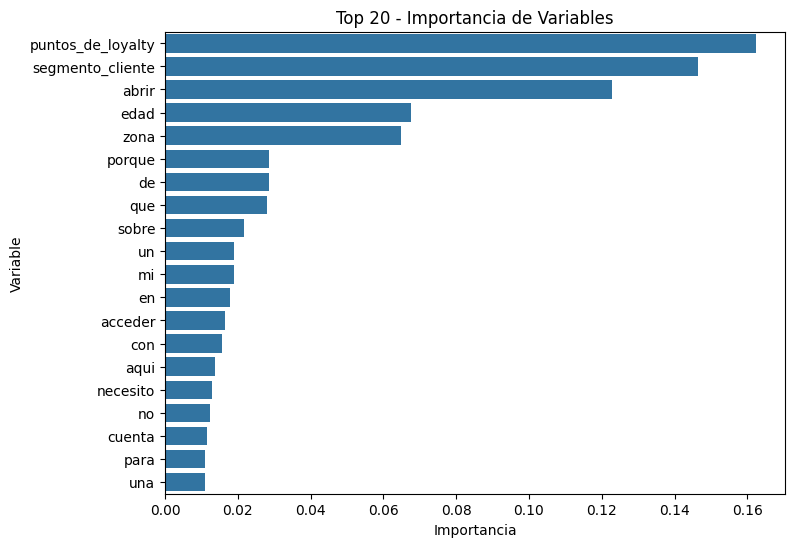

In [58]:
plot_feature_importance(
    model=pipeline['model'],
    top_n=20,
    figsize=(8, 6),
    feature_names=feature_names
)

In [59]:
train_data_shap_tfid = pipeline["features"]["tfidf"].transform(
    train_data["descripcion_atencion"])
train_data_shap_preprocessor = pipeline["features"]["preprocessor"].transform(
    train_data.drop(columns=["descripcion_atencion"]))

In [60]:
train_data_shap = pd.concat([
        pd.DataFrame(train_data_shap_tfid.toarray()).reset_index(drop=True),
        train_data_shap_preprocessor.reset_index(drop=True)
    ],
    axis=1,
    ignore_index=True
)

/workspaces/challenge_ds_place/.venv/lib/python3.10/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


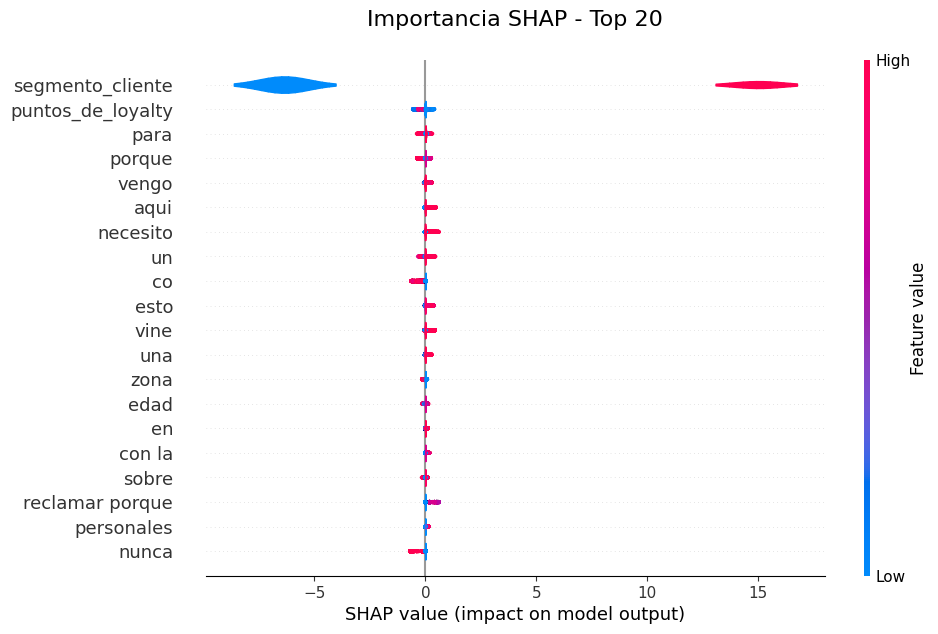

In [61]:
plot_shap_importance(
    model=pipeline["model"],
    train_data=train_data_shap,
    top_n=20,
    figsize=(10, 6),
    feature_names=feature_names,
)

Los resultados obtenidos son atípicamente positivos. Esto podria indicar problemas en la generación de las variables. En una primera inspección parece que el segmento del cliente tiene una fuerte relación con la variable objetivo, lo que podría indicar una filtración de datos. Vamos a intentar inspeccionar con mayor detalle esa variable, dado que el mecanismo de codificación utlizado no lo permite.

In [62]:
pipeline_one_hot = Pipeline(
    steps=[
        ("one_hot", OneHotEncoder(
            variables=categorical_to_encode)
         ),
        ("model", LGBMClassifier(
            random_state=SEED,
            n_jobs=N_JOBS,
            verbose=-1)
         ),
    ]
)

In [63]:
pipeline_one_hot.fit(
    train_data[categorical_to_encode],
    train_target
)
scores = pipeline_one_hot.predict_proba(
    test_data[categorical_to_encode])[:, -1]

In [64]:
metrics = compute_metrics(
    y_true=test_target,
    y_score=scores,
    y_pred=np.where(
        scores > 0.5,
        1,
        0
    )
)
for m, s in metrics.items():
    print(f'{m}: {s:.4f}')

roc_score: 1.0000
ks_statistic: 1.0000
pr_score: 1.0000
accuracy_score: 1.0000
balanced_accuracy_score: 1.0000
precision_score: 1.0000
precision_score_weighted: 1.0000
recall_score: 1.0000
recall_score_weighted: 1.0000
f1_score: 1.0000
f1_score_weighted: 1.0000
business_metric: 713864.0000


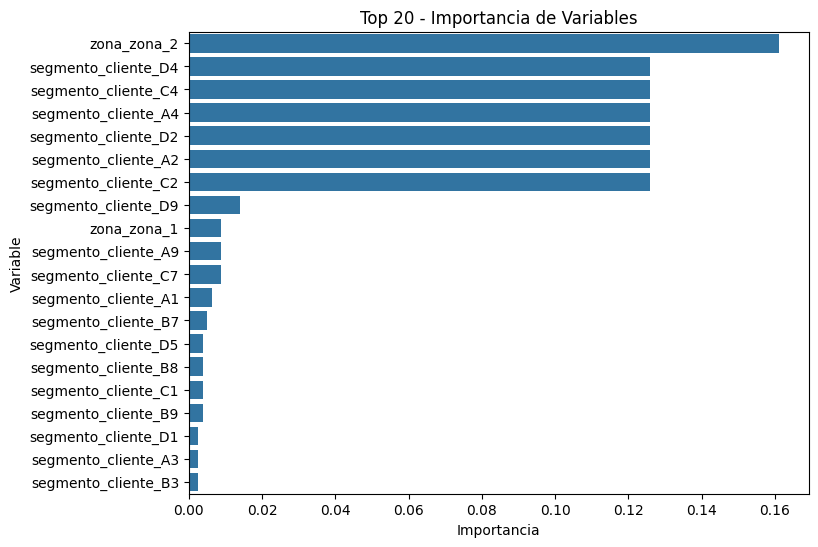

In [65]:
plot_feature_importance(
    model=pipeline_one_hot['model'],
    top_n=20,
    figsize=(8, 6)
)

In [66]:
train_data_shap_preprocessor = pipeline_one_hot["one_hot"].transform(
    train_data[categorical_to_encode])

/workspaces/challenge_ds_place/.venv/lib/python3.10/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


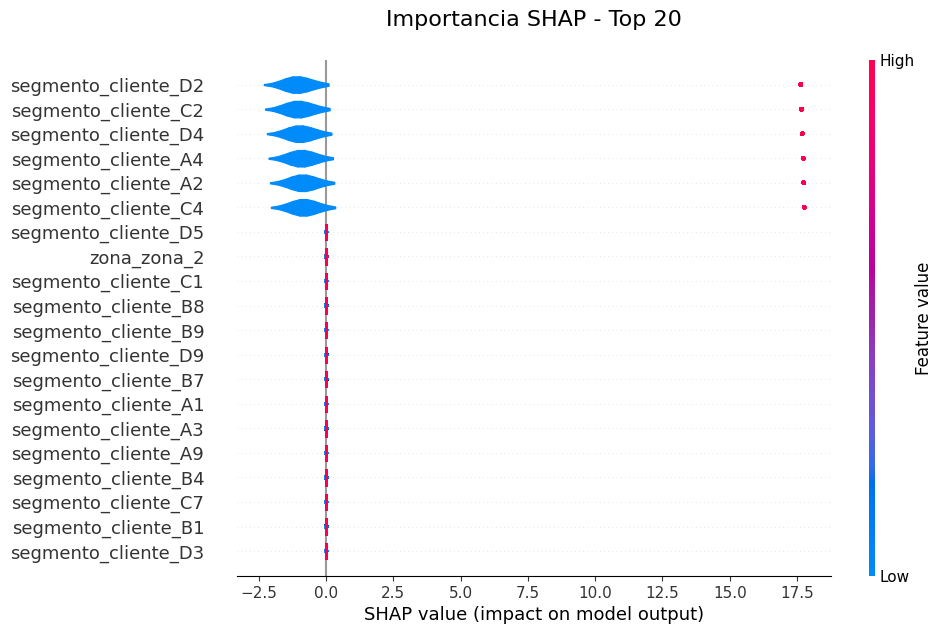

In [67]:
plot_shap_importance(
    model=pipeline_one_hot["model"],
    train_data=train_data_shap_preprocessor,
    top_n=20,
    figsize=(10, 6)
)

Efectivamente parece que los segmentos 2 y 4 presentan una relación directa con la variable objetivo, esto indicaría una posible filtración de datos que requeriría evaluar las condiciones generadoras del conjunto de datos. En caso de no ser algún error, no se aconsejaría el desarrollo de un modelo de machine learning, con una simple regla ya sería suficiente para cumplir el objetivo, reduciendo costos y optimizando los tiempos, pero sería bastante atípico.

## Conclusiones

En el presente se experimentó el desarrollo de diferentes algoritmos de Machine Learning para la problemática planteada. En el mismo se evidencia una posible filtración de datos en la variable asociada al segento del cliente respecto de la variable objetivo.

Los resultados obtenidos son atípicamente positivos, por lo que no se recomienda su puesta en producción hasta indagar en la condiciones generadoras del conjunto de datos.

El proceso de optimización y selección final de un modelo no se finalizó por lo expuesto anteriormente. No obstante, en caso de avanzar en una eventual implementación, se recomendaría el desarrollo de un endpoint que reciba como parámetros las variables correspondientes y que devuelva el score de baja requerido, esto podría ser utilizado luego que el cliente se registra en el totem y previo a la atención comercial, de esta manera, al momento que el cliente sea atendido por el oficial, además de los motivos indicados por el cliente, tendría a disposición el score correspondiente para su gestión. Esto en el marco de la temporalidad y los datos brindados. Por supuesto, también podría desarrollarse algo en una etapa previa con mayor detalle del comportamiento precedente del cliente.